In [1]:
import pandas as pd
import numpy as np
import dill, pickle
import copy
import os

from collections import Counter
import itertools
from scipy import stats

import matplotlib.pyplot as plt
#from seaborn import kdeplot
from joblib import Parallel, delayed

from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut

# ML Analysis

In [2]:
def create_result_df(path, model):
    result_df = pd.DataFrame(columns=['Algorithm', 'AUCPR',	'AUCROC', 'NPV', 'Precision', 
                                  'Recall', 'Specificity', 'Accuracy',	'F1'])
    
    files = os.listdir(path)
    
    for file in files:
        metrics = []

        with open(path + file, "rb") as f:
            results = dill.load(f)
        
        #Algo name
        metrics.append(results['algo'])
        
        
        if model == 'svm':
            pred_prob = results['param_sorted'][0]['prediction_score']
            y_test = results['param_sorted'][0]['y_test']
            y_pred = [int(i>0) for i in pred_prob]
        else:
            pred_prob = results['param_sorted'][0]['prediction_proba']
            y_test = results['param_sorted'][0]['y_test']
            y_pred = [int(i>0.5) for i in pred_prob]
            
        #AUCPR
        metrics.append(average_precision_score(y_test, pred_prob))
        
        #AUCROC
        metrics.append(roc_auc_score(y_test, pred_prob))
    
        tn = confusion_matrix(y_test, y_pred)[0, 0]
        tp = confusion_matrix(y_test, y_pred)[1, 1]
        fp = confusion_matrix(y_test, y_pred)[0, 1]
        fn = confusion_matrix(y_test, y_pred)[1, 0]

        npv = tn/(tn+fn)
        metrics.append(npv)
        
        precision = tp/(tp+fp)
        metrics.append(precision)

        recall = tp/(tp+fn)
        metrics.append(recall)
        
        specificity = tn/(tn+fp)
        metrics.append(specificity)
        
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        metrics.append(accuracy)
        
        f1 = 2*(precision*recall)/(precision+recall)
        metrics.append(f1)
        
        result_df.loc[len(result_df)] = metrics
    
        
    
    return result_df
    

In [3]:
# XGB

In [4]:
xgb_file_path = '../src/train/results/xgb/'
xgb_res_df = create_result_df(xgb_file_path, 'xgb')

/Users/boses1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


In [5]:
xgb_res_roc = xgb_res_df[xgb_res_df['Algorithm'].str.contains('roc')]

In [6]:
xgb_res_roc = xgb_res_roc[~xgb_res_roc['Algorithm'].str.contains('class_weight')]

In [7]:
xgb_res_roc.sort_values(by='AUCROC', ascending = False)

,Algorithm,AUCPR,AUCROC,NPV,Precision,Recall,Specificity,Accuracy,F1
6,xgb_fs_anova_reliefF_eval_roc,0.881001,0.913793,0.870968,0.833333,0.714286,0.931034,0.860465,0.769231
7,xgb_fs_multisurf_eval_roc,0.866194,0.901478,0.823529,0.888889,0.571429,0.965517,0.837209,0.695652
33,xgb_fs_no_eval_roc,0.851762,0.894089,0.838710,0.750000,0.642857,0.896552,0.813953,0.692308
20,xgb_fs_reliefF_eval_roc,0.770152,0.884236,0.812500,0.727273,0.571429,0.896552,0.790698,0.640000
10,xgb_fs_anovaF_eval_roc,0.773472,0.869458,0.838710,0.750000,0.642857,0.896552,0.813953,0.692308
4,xgb_fs_anova_multisurf_eval_roc,0.643821,0.832512,0.821429,0.600000,0.642857,0.793103,0.744186,0.620690


In [27]:
#Why for the svm aucroc is high but aucor is low? BUt for xgb both are high?
#Its because SVM's decisions are less confident

In [28]:
#At standard threshold, xgb seems to be predicting more 0s than 1s compared to svm.

In [37]:
with open(xgb_file_path + 'xgb_fs_anova_reliefF_eval_roc_results.pik', "rb") as f:
    xgb_anorelief = dill.load(f)

with open(xgb_file_path + 'xgb_fs_multisurf_eval_roc_results.pik', "rb") as f:
    xgb_multisurf = dill.load(f)
            
with open(xgb_file_path + 'xgb_fs_reliefF_eval_roc_results.pik', "rb") as f:
    xgb_relief = dill.load(f)
            
with open(xgb_file_path + 'xgb_fs_anovaF_eval_roc_results.pik', "rb") as f:
    xgb_ano = dill.load(f)
            
with open(xgb_file_path + 'xgb_fs_anova_multisurf_eval_roc_results.pik', "rb") as f:
    xgb_anomultisurf = dill.load(f)

In [38]:
xgb_anorelief['opt_param']

{'colsample_bytree': 0.528414386688919,
 'gamma': 0.3362753390466716,
 'learning_rate': 0.43076846574157246,
 'max_depth': 21,
 'min_child_weight': 1.0,
 'n_estimators': 1838,
 'reg_alpha': 0.01,
 'reg_lambda': 1e-05,
 'subsample': 0.19763022321324158}

In [26]:
def set_tick_fontsize(ax, fs):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fs)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fs)

In [39]:
xgb_anorelief_pred_prob = xgb_anorelief['param_sorted'][0]['prediction_proba']
xgb_anorelief_y_test = xgb_anorelief['param_sorted'][0]['y_test']

xgb_multisurf_pred_prob = xgb_multisurf['param_sorted'][0]['prediction_proba']
xgb_multisurf_y_test = xgb_multisurf['param_sorted'][0]['y_test']

xgb_relief_pred_prob = xgb_relief['param_sorted'][0]['prediction_proba']
xgb_relief_y_test = xgb_relief['param_sorted'][0]['y_test']

xgb_ano_pred_prob = xgb_ano['param_sorted'][0]['prediction_proba']
xgb_ano_y_test = xgb_ano['param_sorted'][0]['y_test']

xgb_anomultisurf_pred_prob = xgb_anomultisurf['param_sorted'][0]['prediction_proba']
xgb_anomultisurf_y_test = xgb_anomultisurf['param_sorted'][0]['y_test']

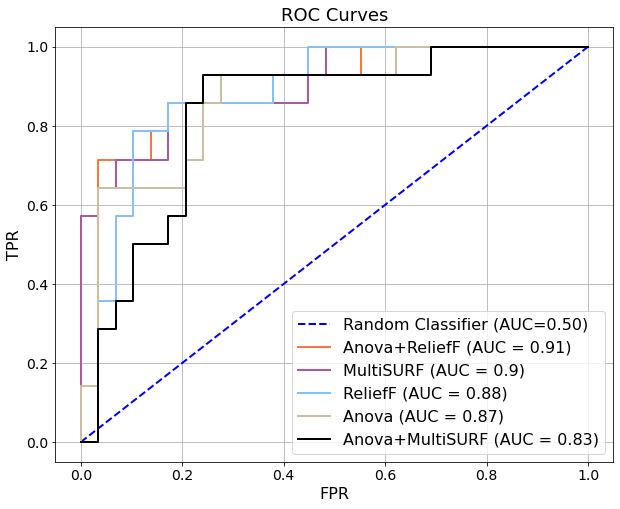

In [45]:
LABEL_FONT_SIZE = 16
TITLE_FONT_SIZE = 18
LEGEND_FONT_SIZE = 16
TICK_FONT_SIZE = 14
MULTI_FIG_SIZE = (16, 14)
SINGLE_FIG_SIZE = (10,8)
MARKER_SIZE = 10

fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
lw = 2

x = np.linspace(0,1,100)

#Random Classifier
ax.plot(x,x,'--b', lw= lw, label='Random Classifier (AUC=0.50)')
    
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(xgb_anorelief_y_test, xgb_anorelief_pred_prob)
roc_xgb = roc_auc_score(xgb_anorelief_y_test, xgb_anorelief_pred_prob)
ax.plot(fpr_xgb, tpr_xgb, '#F5793A', lw = lw, label=f'Anova+ReliefF (AUC = {round(roc_xgb,2)})')

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(xgb_multisurf_y_test, xgb_multisurf_pred_prob)
roc_xgb = roc_auc_score(xgb_multisurf_y_test, xgb_multisurf_pred_prob)
ax.plot(fpr_xgb, tpr_xgb, '#A95AA1', lw = lw, label=f'MultiSURF (AUC = {round(roc_xgb,2)})')

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(xgb_relief_y_test, xgb_relief_pred_prob)
roc_xgb = roc_auc_score(xgb_relief_y_test, xgb_relief_pred_prob)
ax.plot(fpr_xgb, tpr_xgb, '#85C0F9', lw = lw, label=f'ReliefF (AUC = {round(roc_xgb,2)})')

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(xgb_ano_y_test, xgb_ano_pred_prob)
roc_xgb = roc_auc_score(xgb_ano_y_test, xgb_ano_pred_prob)
ax.plot(fpr_xgb, tpr_xgb, '#CCBE9F', lw = lw, label=f'Anova (AUC = {round(roc_xgb,2)})')

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(xgb_anomultisurf_y_test, xgb_anomultisurf_pred_prob)
roc_xgb = roc_auc_score(xgb_anomultisurf_y_test, xgb_anomultisurf_pred_prob)
ax.plot(fpr_xgb, tpr_xgb, 'black', lw = lw, label=f'Anova+MultiSURF (AUC = {round(roc_xgb,2)})')

# ax.set_xlim(0,1)
# ax.set_ylim(0,)

ax.set_xlabel('FPR', fontsize=LABEL_FONT_SIZE)
ax.set_ylabel('TPR', fontsize=LABEL_FONT_SIZE)
set_tick_fontsize(ax, TICK_FONT_SIZE)
ax.set_title('ROC Curves', fontsize=TITLE_FONT_SIZE)
ax.legend(loc="lower right", fontsize=LEGEND_FONT_SIZE)
ax.grid();



In [46]:
img_out_path = '../reports/figures/'
fig.savefig(img_out_path+'ROC.pdf', dpi=300, bbox_inches='tight', pad_inches=.15)

In [356]:
feature_set = set([])
for split in xgb_results['cv_data']:
    selected_features = split[4]
#     print(len(selected_features))
    feature_set = feature_set.union(set(selected_features))
    

In [352]:
len(feature_set)

58

In [122]:
xgb_feature_set_dict = dict.fromkeys(list(feature_set), 0)

In [123]:
for split in xgb_results['cv_data']:
    for feat in split[4]:
        xgb_feature_set_dict[feat]+=1

In [124]:
sorted(xgb_feature_set_dict.items(), key=lambda x: x[1], reverse=True)

[('M72T2_2', 43),
 ('M138T4', 43),
 ('M77T3_1', 43),
 ('M82T2_2', 43),
 ('M98T6_2', 43),
 ('M84T6_1', 43),
 ('M110T12_2', 43),
 ('M93T11_1', 42),
 ('M151T1', 42),
 ('M38T11', 40),
 ('M127T6', 40),
 ('M94T11_1', 39),
 ('M97T3_1', 39),
 ('M100T4_1', 32),
 ('M63T7_2', 26),
 ('M84T4_1', 23),
 ('M108T7', 22),
 ('M39T7_1', 20),
 ('M95T2', 19),
 ('M58T7', 18),
 ('M69T2_1', 16),
 ('M107T7_2', 15),
 ('M90T2_2', 13),
 ('M69T4_1', 11),
 ('M100T3_1', 9),
 ('M56T2_1', 5),
 ('M166T6_1', 5),
 ('M131T2_1', 3),
 ('M100T6', 3),
 ('M50T11_2', 2),
 ('M69T6_1', 2),
 ('M98T2_1', 1),
 ('M131T7', 1),
 ('M50T2', 1),
 ('M86T3_4', 1),
 ('M170T6', 1),
 ('M86T2_1', 1),
 ('M139T2', 1),
 ('M96T6_3', 1),
 ('M63T11_1', 1),
 ('M43T2_3', 1),
 ('M90T3_1', 1),
 ('M94T3', 1),
 ('M85T5_3', 1),
 ('M83T3_3', 1),
 ('M90T12', 1),
 ('M74T11_2', 1),
 ('M155T2_2', 1),
 ('M100T3_2', 1),
 ('M104T2', 1),
 ('M69T10_3', 1),
 ('M46T4', 1),
 ('M137T4', 1),
 ('M68T2_1', 1),
 ('M89T12_3', 1),
 ('M103T12_2', 1),
 ('M112T3_1', 1),
 ('M43T5_3

In [125]:
counter = 1
for split in xgb_results['cv_data']:
    print(f'split {counter} | {len(split[4])}/58')
    counter+=1

split 1 | 23/58
split 2 | 14/58
split 3 | 14/58
split 4 | 27/58
split 5 | 26/58
split 6 | 19/58
split 7 | 13/58
split 8 | 24/58
split 9 | 21/58
split 10 | 17/58
split 11 | 25/58
split 12 | 16/58
split 13 | 26/58
split 14 | 14/58
split 15 | 22/58
split 16 | 21/58
split 17 | 25/58
split 18 | 19/58
split 19 | 22/58
split 20 | 22/58
split 21 | 25/58
split 22 | 22/58
split 23 | 19/58
split 24 | 20/58
split 25 | 25/58
split 26 | 20/58
split 27 | 26/58
split 28 | 22/58
split 29 | 19/58
split 30 | 15/58
split 31 | 17/58
split 32 | 14/58
split 33 | 15/58
split 34 | 20/58
split 35 | 21/58
split 36 | 14/58
split 37 | 13/58
split 38 | 13/58
split 39 | 9/58
split 40 | 12/58
split 41 | 19/58
split 42 | 12/58
split 43 | 12/58


# Appendix

In [110]:
# LR

In [8]:
lr_file_path = '../src/train/results/lr/'
lr_res_df = create_result_df(lr_file_path, 'lr')

In [9]:
lr_res_roc = lr_res_df[lr_res_df['Algorithm'].str.contains('roc')]

In [10]:
lr_res_roc = lr_res_roc[~lr_res_roc['Algorithm'].str.contains('class_weight')]

In [11]:
lr_res_roc.sort_values(by='AUCPR', ascending = False)

,Algorithm,AUCPR,AUCROC,NPV,Precision,Recall,Specificity,Accuracy,F1
24,lr_fs_no_eval_roc,0.786986,0.849754,0.823529,0.888889,0.571429,0.965517,0.837209,0.695652
12,lr_fs_multisurf_eval_roc,0.734863,0.820197,0.771429,0.750000,0.428571,0.931034,0.767442,0.545455
21,lr_fs_reliefF_eval_roc,0.667865,0.825123,0.787879,0.700000,0.500000,0.896552,0.767442,0.583333
15,lr_fs_anovaF_eval_roc,0.613448,0.768473,0.717949,0.750000,0.214286,0.965517,0.720930,0.333333
6,lr_fs_anova_reliefF_eval_roc,0.581527,0.746305,0.717949,0.750000,0.214286,0.965517,0.720930,0.333333
29,lr_fs_anova_multisurf_eval_roc,0.456142,0.652709,0.675000,0.333333,0.071429,0.931034,0.651163,0.117647


In [126]:
# SVM

In [409]:
svm_file_path = '../src/train/results/svm/'
svm_res_df = create_result_df(svm_file_path, 'svm')

In [423]:
svm_file_path = '../src/train/results/svm_lim_vector2/'
svm_res_df = create_result_df(svm_file_path, 'svm')

/Users/boses1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars
/Users/boses1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars
/Users/boses1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


In [424]:
svm_res_df.sort_values(by='AUCPR', ascending = False)

,Algorithm,AUCPR,AUCROC,NPV,Precision,Recall,Specificity,Accuracy,F1
3,svm_fs_anovaF_cb_class_weight_eval_apr,0.797353,0.770936,0.862069,0.714286,0.714286,0.862069,0.813953,0.714286
2,svm_fs_anova_reliefF_cb_class_weight_eval_apr,0.796367,0.768473,0.857143,0.666667,0.714286,0.827586,0.790698,0.689655
1,svm_fs_anova_multisurf_cb_class_weight_eval_apr,0.640867,0.743842,0.771429,0.750000,0.428571,0.931034,0.767442,0.545455
0,svm_fs_no_cb_class_weight_eval_apr,0.325581,0.000000,0.674419,NaN,0.000000,1.000000,0.674419,NaN
4,svm_fs_reliefF_cb_class_weight_eval_apr,0.195571,0.000000,0.674419,NaN,0.000000,1.000000,0.674419,NaN
5,svm_fs_multisurf_cb_class_weight_eval_apr,0.195571,0.000000,0.674419,NaN,0.000000,1.000000,0.674419,NaN


In [425]:
svm_file_path

'../src/train/results/svm_lim_vector2/'

In [455]:
with open(svm_file_path + 'svm_fs_anovaF_cb_class_weight_eval_apr_results.pik', "rb") as f:
            svm_results = dill.load(f)

In [456]:
svm_results.keys()

dict_keys(['algo', 'cv_data', 'trials', 'opt_param', 'param_sorted'])

In [457]:
svm_pred_score = svm_results['param_sorted'][0]['prediction_score']

In [458]:
svm_results['opt_param']

{'C': 65.02664396742932,
 'class_weight': 'balanced',
 'gamma': 'auto',
 'kernel': 'rbf',
 'probability': True}

How do you check for overfitting? You cant do learning curves when model was trained using feature selection embedded in LOO because each training split in LOO has a different set of features. So there is no single set of features to be used for learning curve.

In regular k fold CV, you can pick hyperparamters for the median performing split and then do learning curve analysis for the median performing split. 

If we dont control for the number of support vectors in SVM, we are overfitting the dataset even with LOO as is evidenced by the number of support vectors in the learnt model

In [443]:
# svm_res_df.sort_values(by='AUCPR', ascending = False)

In [220]:
y_test = svm_results['param_sorted'][0]['y_test']

In [221]:
svm_pred = [int(i>=0.) for i in svm_pred_score]

In [222]:
confusion_matrix(y_test, svm_pred)

array([[29,  0],
       [ 0, 14]])

In [459]:
feature_set = set([])
for split in svm_results['cv_data']:
    selected_features = split[4]
#     print(len(selected_features))
    feature_set = feature_set.union(set(selected_features))
    

In [460]:
len(feature_set)

66

In [461]:
svm_feature_set_dict = dict.fromkeys(list(feature_set), 0)

In [462]:
for split in svm_results['cv_data']:
    for feat in split[4]:
        svm_feature_set_dict[feat]+=1

In [463]:
sorted_features = sorted(svm_feature_set_dict.items(), key=lambda x: x[1], reverse=True)

In [464]:
important_features = []
for feat in sorted_features:
    if feat[1]>=22:
        important_features.append(feat)
    

In [465]:
important_features

[('M77T3_1', 43),
 ('M82T2_2', 43),
 ('M110T12_2', 43),
 ('M72T2_2', 43),
 ('M138T4', 43),
 ('M39T7_1', 43),
 ('M98T6_2', 43),
 ('M84T6_1', 43),
 ('M93T11_1', 42),
 ('M151T1', 42),
 ('M108T7', 42),
 ('M63T7_2', 41),
 ('M58T7', 40),
 ('M38T11', 40),
 ('M127T6', 40),
 ('M94T11_1', 39),
 ('M97T3_1', 39),
 ('M100T4_1', 32),
 ('M84T4_1', 23),
 ('M90T2_2', 22),
 ('M67T2_1', 22)]

In [397]:
# HAVE to reload svm_fs_no_cb_class_weight_eval_apr for this to work
params = svm_results['opt_param']

In [398]:
params

{'C': 65.02664396742932,
 'class_weight': 'balanced',
 'gamma': 'auto',
 'kernel': 'rbf',
 'probability': True}

In [399]:
data.head()

,M151T1,M83T1,M101T1,M46T1,M49T1,M66T1,M62T1,M80T1,M137T1,M135T1,...,M110T26_1,M121T26_1,M175T26_1,M124T26_1,M138T26_2,M85T26_2,M174T26,M123T26_1,M91T26,M94T26
0,16.048388,6064.292377,781.993514,802.020931,4694.204132,7.292742e+04,29491.232768,16.024791,1710.311517,610.786947,...,7867.025232,8965.565729,3012.051770,4658.714325,2340.026084,12912.976187,1397.742432,16170.724464,10359.088145,4524.513159
1,2966.261917,134774.774889,62570.597315,18605.033364,23763.284044,6.268676e+06,392830.377721,5189.617648,1061.179026,63189.361143,...,278936.880991,323372.411031,79971.903683,215630.572047,79703.417540,524443.694141,58370.370030,714891.705277,330847.552709,229032.808630
2,8377.442132,54888.286191,7574.412552,24452.053496,8865.881271,8.122816e+05,470305.922774,2883.659359,4927.060920,68984.802047,...,330297.442948,400547.227331,89001.852491,237332.546382,92068.988978,281554.565002,73030.972156,942769.300372,653550.454878,189904.532666
3,37.609095,10440.984838,26.750624,88.923190,1827.264205,4.491165e+04,8166.159143,1374.437507,732.478087,1881.366829,...,1090.182759,998.434986,220.276019,648.220851,375.745446,1799.311194,106.666198,1713.346412,2279.341711,655.383157
4,115.438628,7287.725513,112.578791,28.656514,5843.718655,1.573132e+05,21056.733832,3441.212011,170.831961,284.265511,...,9453.592618,17333.718556,1887.790859,8186.847903,3752.941527,10702.205663,2548.940100,33661.377548,16464.790716,7288.223731


In [400]:
score_arr = []
pred_prob_arr = []
for train_index, test_index in loo.split(data.to_numpy()):
    x_train = data.iloc[train_index, :].to_numpy()
    y_train = labels.iloc[train_index].to_numpy()
    
    x_test = data.iloc[test_index, :].to_numpy()
    y_test = labels.iloc[test_index].to_numpy()

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    print(x_train.shape)
    x_test = scaler.transform(x_test)
    print(x_test.shape)
    
    clf = SVC(random_state = 927364913, **params)
    clf.fit(x_train,y_train)
    
    print('num_sv', clf.n_support_)
#     print('sv', )
    
    pred_prob_arr.append(clf.predict_proba(x_test))
    score_arr.append(clf.decision_function(x_test)[0])
      

(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [23 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [23 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [22 12]
(42, 2734)
(1, 2734)
num_sv [23 12]
(42, 2734)
(1, 2734)
num_sv [23 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv [23 12]
(42, 2734)
(1, 2734)
num_sv [23 12]
(42, 2734)
(1, 2734)
num_sv [22 12]
(42, 2734)
(1, 2734)
num_sv [23 12]
(42, 2734)
(1, 2734)
num_sv [24 12]
(42, 2734)
(1, 2734)
num_sv 

In [214]:
score_arr

[-0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 -0.05850235349965366,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457,
 0.7479898618476457]

In [ ]:
#Comparing XGBoost with SVM classifier

In [27]:
xgb_pred_prob = xgb_results['param_sorted'][0]['prediction_proba']
xgb_y_test = xgb_results['param_sorted'][0]['y_test']

In [30]:
svm_score = y_score_arr
svm_y_test = y_test_arr

In [58]:
test = pd.DataFrame()
test['xgb'] = xgb_pred_prob
test['svm'] = svm_score
test['true'] = svm_y_test

In [59]:
test

,xgb,svm,true
0,0.261795,-1.064547,0
1,0.005094,-1.087912,0
2,0.020211,-1.012101,0
3,0.041748,-1.364575,0
4,0.370545,-1.164196,0
5,0.036706,-1.089513,0
6,0.012293,-1.012878,0
7,0.106968,-1.180552,0
8,0.019604,-1.091651,0
9,0.124471,-0.867862,0


In [51]:
def set_tick_fontsize(ax, fs):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fs)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fs)

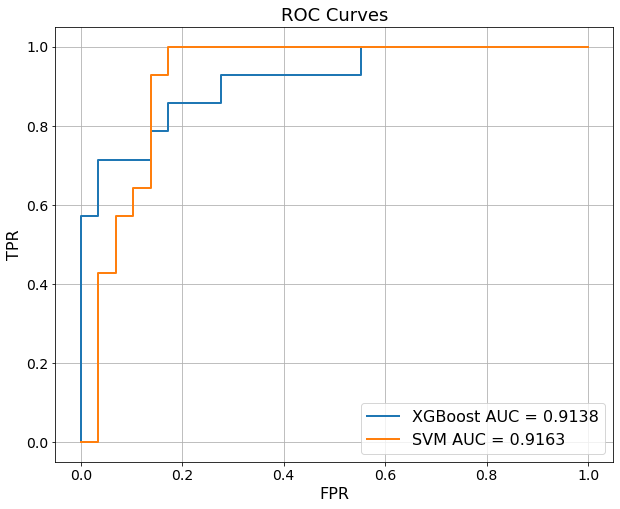

In [53]:
LABEL_FONT_SIZE = 16
TITLE_FONT_SIZE = 18
LEGEND_FONT_SIZE = 16
TICK_FONT_SIZE = 14
MULTI_FIG_SIZE = (16, 14)
SINGLE_FIG_SIZE = (10,8)
MARKER_SIZE = 10

fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
lw = 2

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(xgb_y_test, xgb_pred_prob)
roc_xgb = roc_auc_score(xgb_y_test, xgb_pred_prob)
ax.plot(fpr_xgb, tpr_xgb, lw = lw, label=f'XGBoost AUC = {round(roc_xgb,4)}')

fpr_svm, tpr_svm, thresholds_svm = roc_curve(svm_y_test, svm_score)
roc_svm = roc_auc_score(svm_y_test, svm_score)
ax.plot(fpr_svm, tpr_svm, lw = lw, label=f'SVM AUC = {round(roc_svm,4)}')


# ax.set_xlim(0,1)
# ax.set_ylim(0,)

ax.set_xlabel('FPR', fontsize=LABEL_FONT_SIZE)
ax.set_ylabel('TPR', fontsize=LABEL_FONT_SIZE)
set_tick_fontsize(ax, TICK_FONT_SIZE)
ax.set_title('ROC Curves', fontsize=TITLE_FONT_SIZE)
ax.legend(loc="lower right", fontsize=LEGEND_FONT_SIZE)
ax.grid();



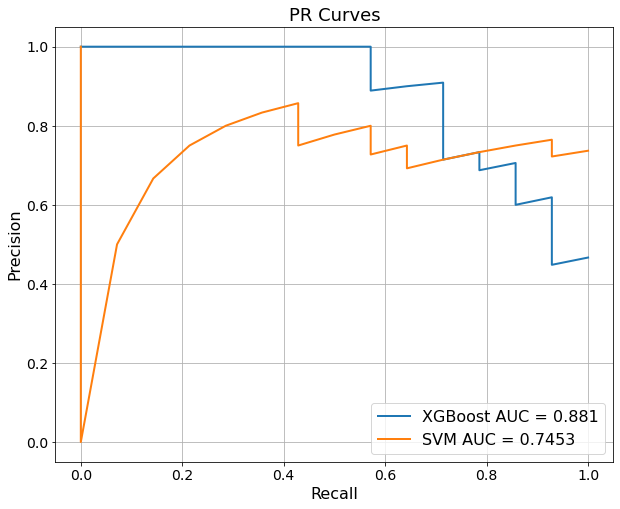

In [54]:
LABEL_FONT_SIZE = 16
TITLE_FONT_SIZE = 18
LEGEND_FONT_SIZE = 16
TICK_FONT_SIZE = 14
MULTI_FIG_SIZE = (16, 14)
SINGLE_FIG_SIZE = (10,8)
MARKER_SIZE = 10

fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
lw = 2

prec_xgb, rec_xgb, thresholds_xgb = precision_recall_curve(xgb_y_test, xgb_pred_prob)
apr_xgb = average_precision_score(xgb_y_test, xgb_pred_prob)
ax.plot(rec_xgb, prec_xgb, lw = lw, label=f'XGBoost AUC = {round(apr_xgb,4)}')

prec_svm, rec_svm, thresholds_svm = precision_recall_curve(svm_y_test, svm_score)
apr_svm = average_precision_score(svm_y_test, svm_score)
ax.plot(rec_svm, prec_svm, lw = lw, label=f'SVM AUC = {round(apr_svm,4)}')


# ax.set_xlim(0,1)
# ax.set_ylim(0,)

ax.set_xlabel('Recall', fontsize=LABEL_FONT_SIZE)
ax.set_ylabel('Precision', fontsize=LABEL_FONT_SIZE)
set_tick_fontsize(ax, TICK_FONT_SIZE)
ax.set_title('PR Curves', fontsize=TITLE_FONT_SIZE)
ax.legend(loc="lower right", fontsize=LEGEND_FONT_SIZE)
ax.grid();



In [55]:
prec_svm

array([0.73684211, 0.72222222, 0.76470588, 0.75      , 0.73333333,
       0.71428571, 0.69230769, 0.75      , 0.72727273, 0.8       ,
       0.77777778, 0.75      , 0.85714286, 0.83333333, 0.8       ,
       0.75      , 0.66666667, 0.5       , 0.        , 1.        ])

In [56]:
rec_svm

array([1.        , 0.92857143, 0.92857143, 0.85714286, 0.78571429,
       0.71428571, 0.64285714, 0.64285714, 0.57142857, 0.57142857,
       0.5       , 0.42857143, 0.42857143, 0.35714286, 0.28571429,
       0.21428571, 0.14285714, 0.07142857, 0.        , 0.        ])

In [57]:
thresholds_svm

array([-0.29420402, -0.20335776, -0.02039303,  0.11559973,  0.15593763,
        0.32431974,  0.35569103,  0.41126071,  0.44947449,  0.52758855,
        0.5424331 ,  0.55168925,  0.66081418,  0.67303722,  0.69326761,
        0.80160298,  1.01074036,  1.11080078,  1.14207473])